# Example of the `aitlas` toolbox in the context of image segmentation

This notebook shows a sample implementation of a image segmentation using the `aitlas` toolbox.

In [1]:
%matplotlib inline

Import the required packages

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os

from aitlas.datasets import ChactunDataset
from aitlas.models import DeepLabV3
from aitlas.tasks.predict import ImageFolderDataset
from aitlas.visualizations import display_image_segmentation

2021-04-27 09:15:20,168 INFO Loading faiss with AVX2 support.
2021-04-27 09:15:20,169 INFO Loading faiss.


## Visualize images and masks

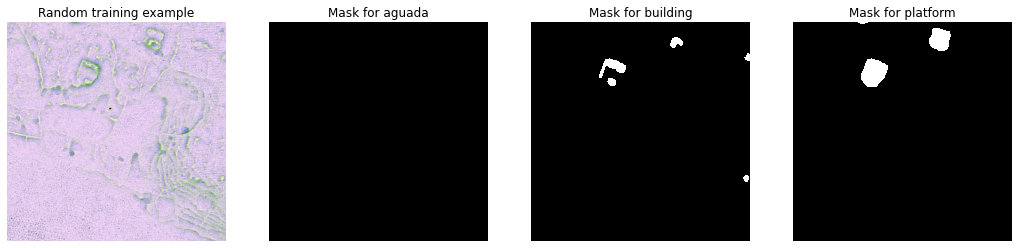

In [3]:
example_image = Image.open('/media/ssd/Chactun/train/tile_1185_lidar.tif')
example_mask1 = Image.open('/media/ssd/Chactun/train/tile_1185_mask_aguada.tif')
example_mask2 = Image.open('/media/ssd/Chactun/train/tile_1185_mask_building.tif')
example_mask3 = Image.open('/media/ssd/Chactun/train/tile_1185_mask_platform.tif')

plt.rcParams["figure.figsize"] = (18, 9) # (w, h)
plt.subplot(1,4,1)
plt.imshow(example_image)
plt.title(f"Random training example")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(example_mask1, cmap='gray')
plt.title(f"Mask for aguada")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(example_mask2, cmap='Greys',  interpolation='nearest')
plt.title(f"Mask for building")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(example_mask3, cmap='Greys',  interpolation='nearest')
plt.title(f"Mask for platform")
plt.axis('off')
plt.show()

## Load data

In [4]:
train_dataset_config = {
    "batch_size": 4,
    "shuffle": True,
    "num_workers": 4,
    "root": "/media/ssd/chactun_new/train",
    "transforms": ["aitlas.transforms.MinMaxNormTransponse"],
    "target_transforms": ["aitlas.transforms.MinMaxNorm"]
}
train_dataset = ChactunDataset(train_dataset_config)
len(train_dataset)

1764

## Training

In [6]:
epochs = 5
model_directory = "/media/ssd/chactun_new/experiments/"
model_config = {"num_classes": 3, "learning_rate": 0.0001,"pretrained": True, "threshold": 0.5}

model = DeepLabV3(model_config)
model.prepare()

model.train_model(
    train_dataset=train_dataset,
    epochs=epochs,
    model_directory=model_directory,
    run_id='1'
)


2021-04-27 00:19:59,886 INFO Starting training.
training: 100%|██████████| 441/441 [26:48<00:00,  3.65s/it]
2021-04-27 00:46:48,651 INFO epoch: 1, time: 1609, loss:  0.00953
testing on train set: 100%|██████████| 441/441 [02:08<00:00,  3.44it/s]
2021-04-27 00:48:57,793 INFO IOU mean:0.722846107463058, IOU pre Class:0.963718820861678, 0.6328794900102218, 0.5719399468897979
training: 100%|██████████| 441/441 [26:52<00:00,  3.66s/it]
2021-04-27 01:15:50,057 INFO epoch: 2, time: 1613, loss:  0.00586
testing on train set: 100%|██████████| 441/441 [02:08<00:00,  3.44it/s]
2021-04-27 01:17:58,154 INFO IOU mean:0.7841773900757821, IOU pre Class:0.9749535495805229, 0.6798431581490628, 0.6977353923868408
training: 100%|██████████| 441/441 [26:52<00:00,  3.66s/it]
2021-04-27 01:44:50,158 INFO epoch: 3, time: 1612, loss:  0.00484
testing on train set: 100%|██████████| 441/441 [02:08<00:00,  3.44it/s]
2021-04-27 01:46:58,220 INFO IOU mean:0.7981491227573029, IOU pre Class:0.9783444103960143, 0.6893

## Evaluation

In [7]:
test_dataset_config = {
    "batch_size": 4,
    "shuffle": False,
    "num_workers": 4,
    "root": "/media/ssd/chactun_new/test",
    "transforms": ["aitlas.transforms.MinMaxNormTransponse"],
    "target_transforms": ["aitlas.transforms.MinMaxNorm"]
}

test_dataset = ChactunDataset(test_dataset_config)
len(test_dataset)

model_config = {"num_classes": 3, "learning_rate": 0.0001,"pretrained": True, "threshold": 0.5}
model = DeepLabV3(model_config)
model.prepare()

model_path = "/media/ssd/chactun_new/experiments/checkpoint.pth.tar"
model.evaluate(dataset=test_dataset, model_path=model_path)
model.running_metrics.get_scores(["iou"])

2021-04-27 12:20:58,762 INFO Loading checkpoint /media/ssd/chactun_new/experiments/checkpoint.pth.tar
2021-04-27 12:20:59,179 INFO Loaded checkpoint /media/ssd/chactun_new/experiments/checkpoint.pth.tar at epoch 6
testing on test set: 100%|██████████| 83/83 [00:23<00:00,  3.59it/s]


[{'IOU mean': 0.7552414536974308,
  'IOU pre Class': [0.9681466025127647,
   0.6427991823958499,
   0.6547785086598316]}]

## Predictions

2021-04-27 09:17:44,395 INFO Loading checkpoint /media/ssd/chactun_new/experiments/checkpoint.pth.tar
2021-04-27 09:17:44,736 INFO Loaded checkpoint /media/ssd/chactun_new/experiments/checkpoint.pth.tar at epoch 6
running prediction: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


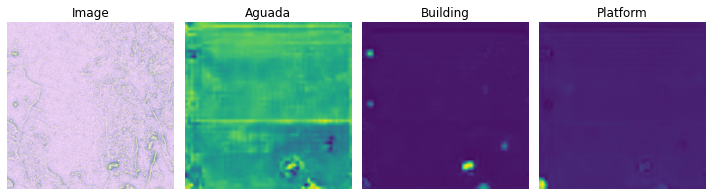

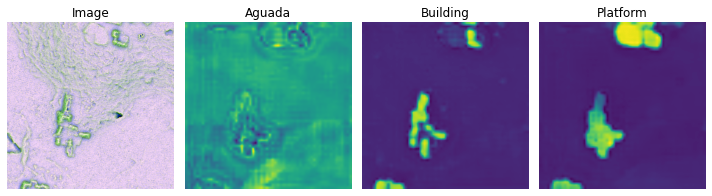

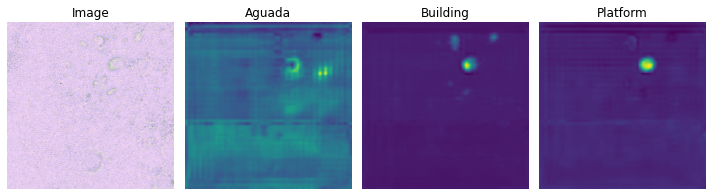

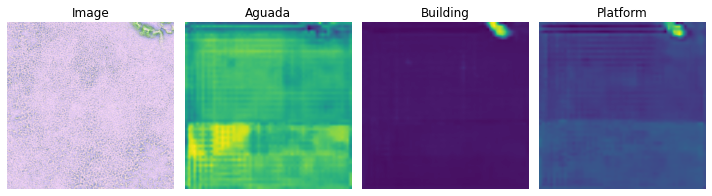

In [5]:
# run predictions
model_path = "/media/ssd/chactun_new/experiments/checkpoint.pth.tar"
predict_dir = "/media/ssd/chactun_new/predict/"
results_dir = "/media/ssd/chactun_new/experiments/results"
labels = ["Aguada", "Building", "Platform"]
transforms = ["aitlas.transforms.MinMaxNormTransponse"]

predict_dataset = ImageFolderDataset(predict_dir, labels, transforms)
len(predict_dataset)

# load the model
model.load_model(model_path)

# Run predictions
y_true, y_pred, y_prob = model.predict(dataset=predict_dataset)

# plot predictions
for i, image_path in enumerate(predict_dataset.data):
    plot_path = os.path.join(results_dir, f"{predict_dataset.fnames[i]}_plot.png")
    display_image_segmentation(
        image_path,
        y_true[i],
        y_pred[i],
        y_prob[i],
        predict_dataset.labels,
        plot_path,
    )